# NBell algorithm evaluation

We estimate precision and recall for algorithm presented in Bell & Keyser paper [1]. We do not reevaluate their algorithm ourselves, but instead simply load the values they provided in the supplementary material.

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import matplotlib, seaborn
import h5py
import scipy
import time
import glob
import os

import Quipu
from Quipu.tools import normaliseLength
from Quipu import augment

%matplotlib inline
%config InlineBackend.figure_format='retina'

# general plotting config
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 10}
matplotlib.rc('font', **font)

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# load data from memory

dataset =         pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/dataset.hdf5")
datasetTestEven = pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestEven.hdf5")
datasetTestOdd =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestOdd.hdf5")
datasetTestMix =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestMix.hdf5")
datasetWithAntibodies =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5")
datasetMultiplexed =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetMultiplexed.hdf5")
datasetExtra =    pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetExtra.hdf5")

print("Fraction of used data: ", dataset.Filter.sum()/ len(dataset))

Fraction of used data:  0.707892204042


In [4]:
# Cases by barcode 

nbCorrect = dataset[ dataset.nbell_barcode == dataset.barcode.apply(lambda x: int(x, 2)) ];
nbAll = dataset[dataset.nbell_barcode < 8];


nbIsolated = pd.DataFrame({
    "Correct": nbCorrect.barcode.value_counts(),
    "All"    : nbAll.barcode.value_counts(),
    "Correct (%)": nbCorrect.barcode.value_counts() / nbAll.barcode.value_counts()
})


# add totals
totals = pd.DataFrame({
    "Correct": nbIsolated["Correct"].sum(),
    "All"    : nbIsolated["All"].sum(),
    "Correct (%)": nbCorrect.barcode.value_counts().sum() / nbAll.barcode.value_counts().sum()
}, index =["Total"])

print("Data discarded: ", 1 - len(nbAll) / len(dataset[dataset.Filter]))
print("Recall: ", len(nbCorrect) / len(dataset[dataset.Filter]))
pd.concat( [nbIsolated,totals ])

Data discarded:  0.8059143439836846
Recall:  0.18198504418762745


,All,Correct,Correct (%)
110,1465,1345,0.918089
111,1331,1303,0.978963
000,982,934,0.951120
011,613,558,0.910277
001,459,423,0.921569
010,456,413,0.905702
101,232,220,0.948276
100,172,158,0.918605
Total,5710,5354,0.937653


In [255]:
model.evaluate(x = prepareTraces(nbAll).reshape(shapeX),
               y = np.vstack( nbAll.barcode.apply(toCategories) )
              )

5696/5710 [============================>.] - ETA: 0s

[0.076467507073391491, 0.98353765323992992]

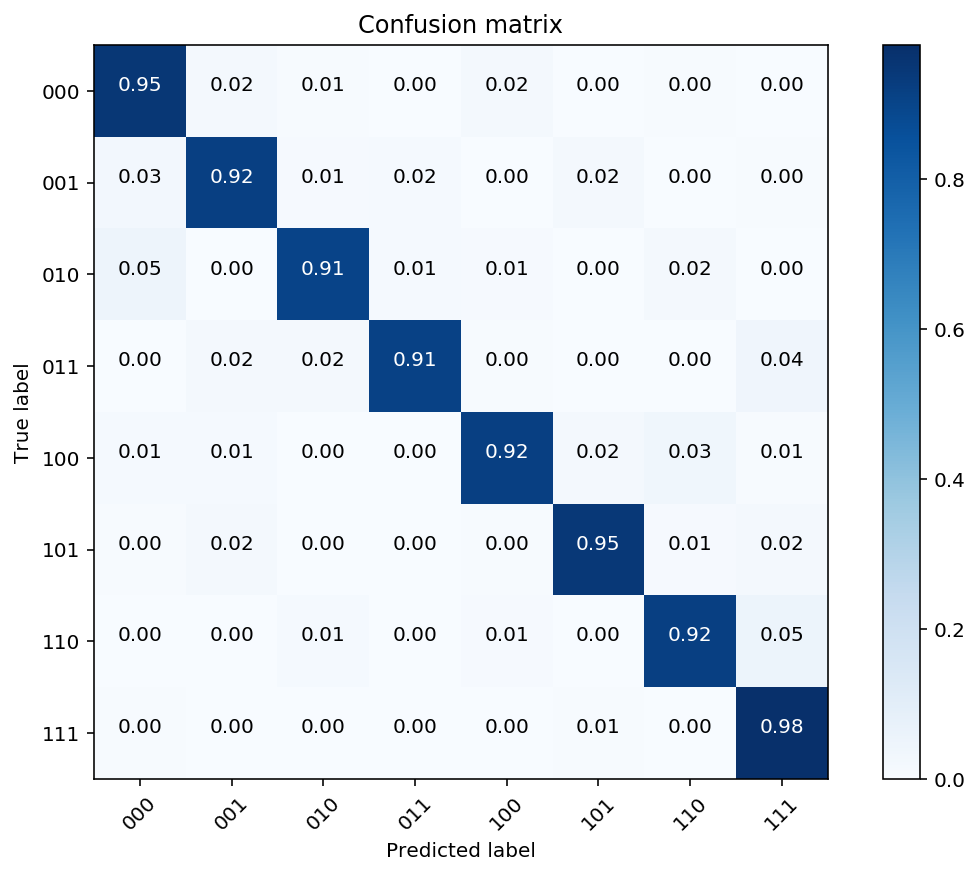

In [5]:
# Confusion matrix for Nicks data

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    "This function prints and plots the confusion matrix."
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

barcodeLabels = ['000','001','010','011','100','101','110','111']
confusionMatrix = confusion_matrix(
    nbAll.barcode.apply(lambda x: int(x, 2)),  # true
    nbAll.nbell_barcode, # predict
    labels=[0,1,2,3,4,5,6,7]
)
    
pyplot.figure(figsize=(8, 6))
plot_confusion_matrix(confusionMatrix, classes=barcodeLabels, title='Confusion matrix')

## Bound state evaluation

We have not imported these originally into the dataset. From NBell description:

> The file timedevents gives the concatenated translocations after steps 1 and 2 in the analysis workflow ie before selection by ECD and removal of unfolded events (see Supplementary Section S2).  The events after steps 4 and 5 in analysis are given with each event in a separate file in order (see Supplementary Section S2).  The ionic current is given in nA.  The sampling frequency is 250kHz. The file peakinfo gives the automated barcode algorithm calls as described in Supplementary Section S2 for the separate files. The barcode "20" denotes a translocation which was unassigned due to step 9 in the barcode determination workflow and barcode "40" denotes a translocation which was unassigned due to step 11.

In [44]:
files = pd.Series(
    glob.glob("/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/*/*/*")
)

files = files[~files.str.contains("tdms")]


for file in files:
    print(file )

/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/011+BrdU(noAB)/NP40/Peak info.dat
/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/011+BrdU(noAB)/NP35/Peak info.dat
/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/011+BrdU(noAB)/NP39/Peak info.dat
/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/011+BrdU(noAB)/NP37/Peak info.dat
/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/011+BrdU(noAB)/NP41/Peak info.dat
/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/011+BrdU(noAB)/NP36/Peak info.dat
/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/011+BrdU(noAB)/NP38/Peak info.dat
/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/111+digoxigenin(ABbound)/NP34/Peak info.dat
/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/111+digoxigenin(ABbound)/NP32/Peak info.dat
/home/kmisiunas/Data/DNA_barcode/raw/individual_with_antibodies/101+puromycin(ABbound)/NP27/Peak i

In [32]:
def loadBindingInfo(file):
    "NBell format"
    return pd.read_table(file)
    
loadBindingInfo( files.iloc[0] ).head()

,1st half peaks,2nd half peaks,Barcode,"Positive barcode (1=true,0=false)",Unnamed: 4
0,3,2,20,0,NaN
1,1,3,2,1,NaN
2,1,3,2,1,NaN
3,3,1,2,1,NaN
4,1,3,2,1,NaN


Ok, there is no record if barcode is bound or not. Will have to rely on the reported numbers in the supplementary PDF. From it:


> <img src="images/table_s3.png" width="600">


In [63]:
# computable table

table_s3 = pd.DataFrame({
    "Assigned_events": np.array([115, 823, 174, 260, 360, 82, 195, 642, 152, 61, 408, 271, 73, 85, 321, 326, 244, 415, 457, 267]),
    "Bound_prediction": np.array([0.922, 0.984, 0.988, 0.992, 0.887, 0.949, 0.909, 0.908, 0.962, 0.982, 0.958, 1.0, 1.0, 0.012, 0.039, 0.039, 0.037, 0.051, 0.063, 0.047 ]),
    "Bound": np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0])
})

accuracy = np.abs( table_s3.Bound_prediction - (1 - table_s3.Bound) )


print("Total assigned events:",  table_s3.Assigned_events.sum())
print("Total events after filtration:", len(datasetWithAntibodies[datasetWithAntibodies.Filter]))
print("Data discarded: ", 1.0 - table_s3.Assigned_events.sum() / len(datasetWithAntibodies[datasetWithAntibodies.Filter]) )
print("Accuracy (weighted):", (accuracy * table_s3.Assigned_events).sum() / table_s3.Assigned_events.sum() )
print("Accuracy (simple):", accuracy.mean())


Total assigned events: 5731
Total events after filtration: 28117
Data discarded:  0.796173133691
Accuracy (weighted): 0.940189670215
Accuracy (simple): 0.90765
